# Data Exploration

## Import Data

In [22]:
from collections import defaultdict
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords

import gensim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
raw_data = pd.read_csv("../data/sample_data.csv")
raw_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Apparentely, we are dealing with data from twitter that seems to be intended for sentiment analysis. Since our task is to train word embeddings the only relevant column is "OriginalTweet", which will serve as a corpus.

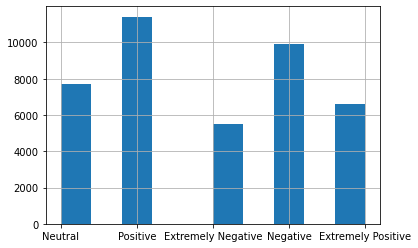

In [21]:
raw_data["Sentiment"].hist();

For a supervised approach, i.e. producing word embeddings with respect to their contribution to the sentiment of the tweet, the classes are mostly balanced.

## Data Inventory

In [3]:
corpus = raw_data[["OriginalTweet"]]

Check for null values in the corpus:

In [4]:
corpus.isnull().any()

OriginalTweet    False
dtype: bool

### Rudimentary Cleaning

As we are dealing with tweets, we are expecting lots of special characters, like # for tags and @ for user-names. In addition, there seem to be urls, that we may need to clean up. To this end, we define a very small test case and develop regular expressions to match and replace them.

In [5]:
test = "#hashtag @username https://this.is.an/url"

First, we replace the usernames with a token "__username__" indicating that this word was a username:

In [6]:
usernames = re.compile("@\w*")

Second, we replace URLs similarly with a token "__url__". To that end, we use the suggested regular expression from https://www.w3resource.com/python-exercises/re/python-re-exercise-42.php:

In [7]:
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

Finally, we match and reformat hashtags, replacing the hash symbol, but retaining the tag itself. When generating word embeddings for tweets to find similarity, finding "similar hashtags" might be of interest. However, this decision might be revisted at a later point.

In [8]:
hashtags = re.compile("#+?(?=\w*)")

Test regular expressions:

In [9]:
def replace_with_tokens(text):
    text = usernames.sub("__username__", text)
    text = urls.sub("__url__", text)
    text = hashtags.sub("__hashtag__", text)
    return text

replace_with_tokens(test)

'__hashtag__hashtag __username__ __url__'

Apply to corpus

In [10]:
clean_corpus = corpus["OriginalTweet"].apply(replace_with_tokens)

### Dictionary

In [11]:
tokenized_clean_corpus = clean_corpus.apply(lambda x: list(tokenize(x)))

For convenience, flatten the different tweets into one big list of tokens:

In [12]:
flat_corpus = []
for token_list in tokenized_clean_corpus.values:
    flat_corpus.extend(token_list)

In [13]:
word_count_dict = defaultdict(int)
for token in flat_corpus:
    word_count_dict[token] += 1
    
print(f"The corpus contains {len(word_count_dict.keys())} unique words!")

The corpus contains 61222 unique words!


The corpus contains a lot of words already (more then 60.000). As a result, stemming might be necessary to keep word counts in check.

Lets see the distribution of different tokens:

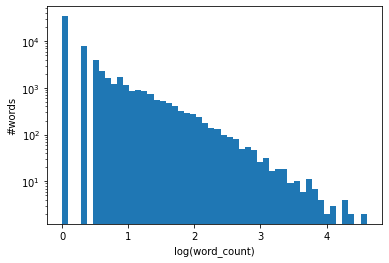

In [14]:
plt.hist([np.log10(word_count) for word_count in word_count_dict.values()], bins=50, log=True)
plt.xlabel("log(word_count)")
plt.ylabel("#words")
plt.show()

What we can see here is a rather large number of very sparsely populated words/tokens (less then 1-10 occurences in the whole corpus), and some highly populated words/tokens, with 10^4 to 10^5 occurences. Overall, the distribution is approximately exponential. Lets investigate both extremes.

In [15]:
sorted_keys = sorted(word_count_dict, key=word_count_dict.get)

In [16]:
sorted_keys[:20]

['poss',
 '__hashtag__ConfinementGeneral',
 'litteraly',
 '__hashtag__CoronavirusFrance',
 'Civics',
 '__hashtag__Rebel',
 '__hashtag__govindia',
 '__hashtag__manila',
 '__hashtag__horningsea',
 'ADARA',
 'Glitch',
 'Stymies',
 'inficted',
 'goverments',
 'guilde',
 'safty',
 'irosponcible',
 '__hashtag__iptvnew',
 '__hashtag__ipTv',
 'IPTVLinks']

Seemingly, the low end is composed of unpopular hashtags and typos. As a result the lower end is not particularly useful for training. As a result, we can focus on the top ~10.000 words. 

In [17]:
sorted_keys[-20:]

['__hashtag__COVID',
 'prices',
 'COVID',
 'at',
 's',
 'you',
 'on',
 'I',
 'are',
 'is',
 '__hashtag__coronavirus',
 'for',
 '__username__',
 'in',
 'a',
 'of',
 'and',
 '__url__',
 'to',
 'the']

The high end is composed of recently popular hashtags concerning the pandemie, our username and url tokens, as well as lots of stopwords. This observation motivates another cleaning step, removing the stopwords from the corpus!

# Conclusion

This small data exploration served the purpose to familiarize ourselves with the data provided. Some observations are:
 - The dataset is quite small and may struggle to produce meaningful embeddings
 - The tweets contain many special characters indicating a function of the words, such as usernames, urls and hashtags.
 - Stopwords are very frequent and should be removed.
 - Some tweets are riddled with typos and may contain more varients of urls, usernames and hashtags that are misspelled.
 
As we are dealing with a rather standard english text, I advocate to apply the standard preprocessing pipeline provided by modules like gensim, as well as tokenize the special words as demonstrated in this notebook. The former includes removal of stopwords, punctuation, and more. (https://radimrehurek.com/gensim/parsing/preprocessing.html)

Note: We are skipping stemming as it may interfer with learning the proper meaning of the words, which may appear as nouns, verbs or adjectives in their stemmed form.

In [31]:
gensim.parsing.preprocessing.strip_punctuation("__hashtag__hashtag")

' hashtag hashtag'

In [32]:
gensim.utils.remove_stopwords(["hello", "is", "and"])

AttributeError: module 'gensim.utils' has no attribute 'remove_stopwords'